In [105]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import betaln
from jax.scipy.special import gammaln
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
from numpy.random import gamma
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp
from scipy.stats import bernoulli

In [46]:
seed = 2022
key = random.PRNGKey(seed)

n = 1000
d = 2

In [123]:
# n of cluster and pi generation
k = 50

alpha = 5.0 #bigger alpha, more clusters
vi = beta.rvs(alpha, 1, size = k)

pi = np.cumprod(vi)

In [121]:
# Z generation

Z = np.zeros((n,k))

for i in range(0, n):
  for j in range(0, k):
    Z[i,j] = bernoulli.rvs(pi[j])

In [129]:
# A generation

A = np.zeros((k,d))
sigma2a = 1.0
Id = np.eye(d)
mu0 = np.zeros(d)

for i in range(0, k):
  A[i] = mvn(mu0, sigma2a*Id)

In [135]:
# Finally X

X = jnp.matmul(Z,A)

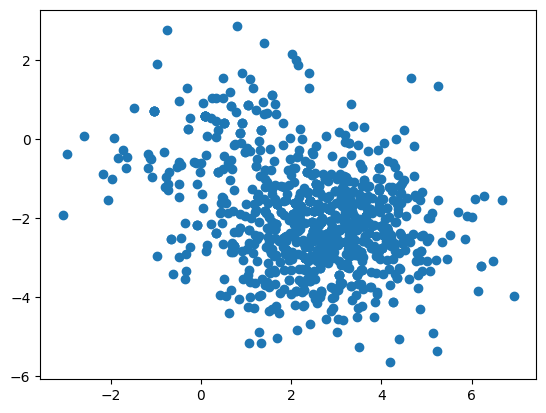

In [140]:
x = X[:,0]
y = X[:,1]

plt.scatter(x, y)
plt.show()